<a href="https://colab.research.google.com/github/KenObata/Music4All_personal_project/blob/main/week11_EDA_on_TF_IDF_en_10genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week11: This notebook is to apply Easy Data Augmentation to balance genres using TF-IDF.

Situation: English only (=multi-class).
Split: StratifiedKfold.
Reference: https://github.com/jasonwei20/eda_nlp


### Preprocess: import files

In [ ]:
#Check RAM size. If small, you can upgrade.
#you can enable a high-RAM runtime via Runtime > Change runtime type in the menu
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 8.8 MB/s 


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
plt.style.use('seaborn')

CSV_FOLDER = 'drive/MyDrive/music4all/'
LANG_DIR = 'drive/MyDrive/music4all/split-language_only-artist_grouped'
SPLIT_DIR = 'drive/MyDrive/music4all/split-all_labels'
FIG_DIR = 'drive/MyDrive/music4all/figures'

font = {'size': 22}

matplotlib.rc('font', **font)

scikit-multilearn has to be installed from pip
https://github.com/scikit-multilearn/scikit-multilearn/issues/142

In [ ]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')

In [ ]:
def analyze_genre_tag_df(df, target_column:int, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[target_column]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, target_column=1,top_n=top_n)

### Data preparation

id_genres.csv

Number of genres: 853


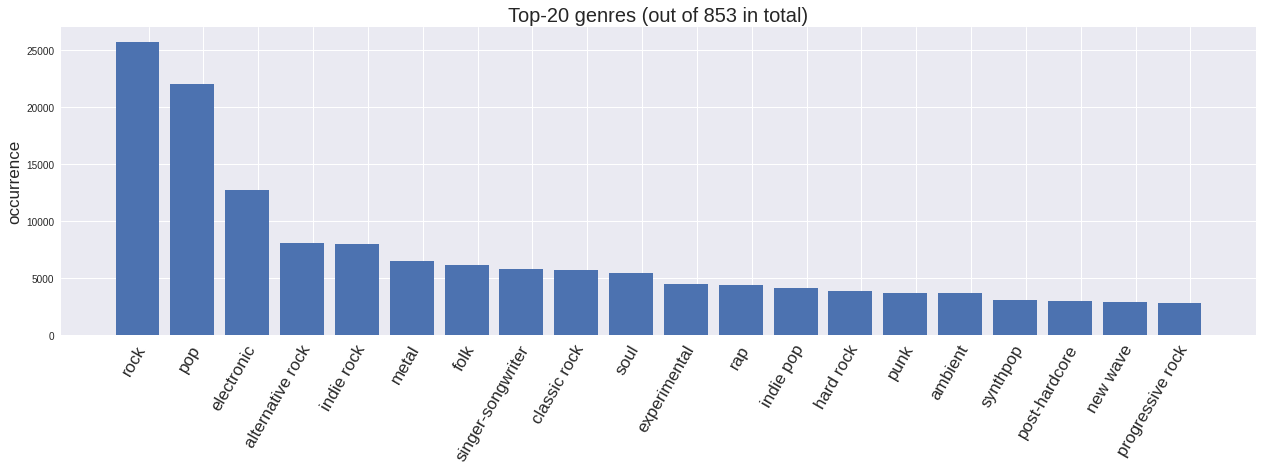

In [ ]:
genre_counter = analyze_genre_tag_csv('id_genres.csv', top_n=20)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-genre.png'))

In [ ]:
genre_counter = sorted(genre_counter.items(), key=lambda item: item[1], reverse = True)
genre_counter_top = genre_counter[:15]

In [ ]:
genre_counter_top_list = [genre for genre, count in genre_counter_top ]
genre_counter_top_list

['rock',
 'pop',
 'electronic',
 'alternative rock',
 'indie rock',
 'metal',
 'folk',
 'singer-songwriter',
 'classic rock',
 'soul',
 'experimental',
 'rap',
 'indie pop',
 'hard rock',
 'punk']

In [ ]:
#filter genre dataset as top15 genre only and later inner join with English.
df_genres = pd.read_csv(os.path.join(CSV_FOLDER, 'id_genres.csv'), header=0, sep='	')
df_genre_top20 = df_genres[df_genres['genres'].isin(genre_counter_top_list)]
df_genre_top20

,id,genres
0,0009fFIM1eYThaPg,pop
11,00P2bHdWFkghmDqz,soul
14,00XWljDxNBgBKEEA,pop
16,00b6fV3nx5z2b8Ls,pop
26,013QDoTqbexEwkHr,pop
...,...,...
109253,zzgS4ZqyswamEWNj,pop
109254,zziALZG1JQ2uUjcy,metal
109262,zzx8CWdM7qkxKQpC,indie rock
109265,zzz0n04uuTUA7fNh,pop


Dataframe narrowed down to 18603 rows. Notice that rank20 has only 169 data. So depending on the result we might need to narrow down to top10 genre?

### Filter only English
 Note that this split have overlapping artist in both sets. See artist-grouped-stratified-split for an improved version.

In [ ]:
en_lang =['en']
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_lang_en

,id,lang
0,0009fFIM1eYThaPg,en
1,0010xmHR6UICBOYT,en
2,002Jyd0vN4HyCpqL,en
3,006TYKNjNxWjfKjy,en
4,007LIJOPQ4Sb98qV,en
...,...,...
109264,zzyyPUs7hC9Nz2e1,en
109265,zzz0n04uuTUA7fNh,en
109266,zzzj3LYaZtYtbzSr,en
109267,zzznMjZAKnJJXQSj,en


Originally it was 109269 rows, and now there are 84103 rows.

### Now, combine split by language and genre, so we classify each genre by language.

In [ ]:
# merge three dataframes into one
df_genre_by_lang = pd.concat([df_genre_top20['id'], df_genre_top20['genres'], df_lang_en['lang']]
                             , join='inner' ,axis=1)

#Do inner join
df_genre_by_lang


,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
11,00P2bHdWFkghmDqz,soul,en
16,00b6fV3nx5z2b8Ls,pop,en
26,013QDoTqbexEwkHr,pop,en
30,01EKNot8qVgZpKM7,rock,en
...,...,...,...
109253,zzgS4ZqyswamEWNj,pop,en
109254,zziALZG1JQ2uUjcy,metal,en
109262,zzx8CWdM7qkxKQpC,indie rock,en
109265,zzz0n04uuTUA7fNh,pop,en


ToDo: concatenate to the dataframe!

In [ ]:
final_genre_list = ["pop", "rock", "soul", "indie rock", "rap", "electronic", "folk", "singer-songwriter", "indie pop", "punk"]
#df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_genre_by_lang = df_genre_by_lang[ df_genre_by_lang["genres"].isin(final_genre_list) ]

After inner join, we can drop the bottom 5, alternative rock, hard rock, experimental, classic rock, and metal

Reindex

In [ ]:
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)
df_genre_by_lang

,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
1,00P2bHdWFkghmDqz,soul,en
2,00b6fV3nx5z2b8Ls,pop,en
3,013QDoTqbexEwkHr,pop,en
4,01EKNot8qVgZpKM7,rock,en
...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en
13536,zzgS4ZqyswamEWNj,pop,en
13537,zzx8CWdM7qkxKQpC,indie rock,en
13538,zzz0n04uuTUA7fNh,pop,en


### Get lyrics document as dataframe and append to X_train, X_test

In [ ]:
#create lyric column
df_genre_by_lang["lyric"] = ""
df_genre_by_lang

,id,genres,lang,lyric
0,0009fFIM1eYThaPg,pop,en,
1,00P2bHdWFkghmDqz,soul,en,
2,00b6fV3nx5z2b8Ls,pop,en,
3,013QDoTqbexEwkHr,pop,en,
4,01EKNot8qVgZpKM7,rock,en,
...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,
13536,zzgS4ZqyswamEWNj,pop,en,
13537,zzx8CWdM7qkxKQpC,indie rock,en,
13538,zzz0n04uuTUA7fNh,pop,en,


In [ ]:
#create temporary lyric folder on google collab
# do not read texts from google drive. it is slow.
ZIP_FILE ="drive/MyDrive/music4all/lyrics.zip"

!unzip drive/MyDrive/music4all/lyrics.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/lyrics/._zdBYCzbDNIMuhViX.txt  
  inflating: /content/lyrics/ZDcFZHxn0FRohOUR.txt  
  inflating: /content/__MACOSX/lyrics/._ZDcFZHxn0FRohOUR.txt  
  inflating: /content/lyrics/zDCpdnbZRALOWkmA.txt  
  inflating: /content/__MACOSX/lyrics/._zDCpdnbZRALOWkmA.txt  
  inflating: /content/lyrics/zDDcHl1LkyDHddfD.txt  
  inflating: /content/__MACOSX/lyrics/._zDDcHl1LkyDHddfD.txt  
  inflating: /content/lyrics/ZdddE8E7syeob5Pm.txt  
  inflating: /content/__MACOSX/lyrics/._ZdddE8E7syeob5Pm.txt  
  inflating: /content/lyrics/ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/__MACOSX/lyrics/._ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/lyrics/zddluWGNq7d8zESq.txt  
  inflating: /content/__MACOSX/lyrics/._zddluWGNq7d8zESq.txt  
  inflating: /content/lyrics/ZDdsBqLxEJrjMseV.txt  
  inflating: /content/__MACOSX/lyrics/._ZDdsBqLxEJrjMseV.txt  
  inflating: /content/lyrics/zddXIHhmYcWpzZvS.txt  
  inflating: /content/__MACOS

### This time, apply stemming and normilize words

In [ ]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [ ]:
text = "This is a test sentence. Yo, 123 today2022"
text= text.replace(',', '')
text = text.replace('.', '')
text_tokens = [stemmer.stem(word) for word in text.split(' ') ]
print(text_tokens)

#text_tokens_alphabet = []
#for word in text.split(' '):
#  temp_word = stemmer.stem(word)
#  print("temp:", temp_word)
#  if temp_word.isalpha():
#    text_tokens_alphabet.append(temp_word)
text_tokens_alphabet = [stemmer.stem(word) for word in text.split(' ') if word.isalpha()]
print(text_tokens_alphabet)

['thi', 'is', 'a', 'test', 'sentenc', 'yo', '123', 'today2022']
['thi', 'is', 'a', 'test', 'sentenc', 'yo']


This study removes "," and "." to get only alphabets.

In [ ]:
#First 5000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

df_genre_by_lang['number_of_line'] = 0
#df_genre_by_lang['text_split'] = []
for idx, row in df_genre_by_lang.loc[0:5000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read()
      number_of_line = lyric_document.count('\n')

      lyric_document = lyric_document.replace('\n', ' ').replace(',', '').replace('.', '')
      lyric_document.lower()
      text_split = [stemmer.stem(word) for word in lyric_document.split(' ') if word.isalpha() ]
      lyric_document=[' '.join(text_split) ]
      
      #df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "text_split"] =text_split
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_line"] = number_of_line
      #print(lyric_document)

  except Exception as e:
    print(e)


In [ ]:
#index 5001 ~ 7988
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[5001:df_genre_by_lang.shape[0]].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read()
      number_of_line = lyric_document.count('\n')

      lyric_document = lyric_document.replace('\n', ' ').replace(',', '').replace('.', '')
      lyric_document.lower()
      text_split = [stemmer.stem(word) for word in lyric_document.split(' ') if word.isalpha() ]
      lyric_document=[' '.join(text_split) ]

      #df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "text_split"] =text_split
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_line"] = number_of_line
      #print(lyric_document)

  except Exception as e:
    print(e)


In [ ]:
#Reindex again
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)

In [ ]:
df_genre_by_lang[0:df_genre_by_lang.shape[0]]

,id,genres,lang,lyric,number_of_line
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,91
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,36
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,74
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,20
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,31
...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,75
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,34
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,65


In [ ]:
df_genre_by_lang.shape[0]

13540

### Apply Data Augmentation Preprocess

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Easy data augmentation techniques for text classification
# Jason Wei and Kai Zou

import random
from random import shuffle
random.seed(1)

#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

#cleaning up text
import re
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

#for the first time you use wordnet
#import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet 

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

	#obviously, if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)
	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

########################################################################
# main data augmentation function
########################################################################

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	
	sentence = get_only_chars(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not '']
	num_words = len(words)
	
	augmented_sentences = []
	num_new_per_technique = int(num_aug/4)+1

	#sr
	if (alpha_sr > 0):
		n_sr = max(1, int(alpha_sr*num_words))
		for _ in range(num_new_per_technique):
			a_words = synonym_replacement(words, n_sr)
			augmented_sentences.append(' '.join(a_words))

	#ri
	if (alpha_ri > 0):
		n_ri = max(1, int(alpha_ri*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_insertion(words, n_ri)
			augmented_sentences.append(' '.join(a_words))

	#rs
	if (alpha_rs > 0):
		n_rs = max(1, int(alpha_rs*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_swap(words, n_rs)
			augmented_sentences.append(' '.join(a_words))

	#rd
	if (p_rd > 0):
		for _ in range(num_new_per_technique):
			a_words = random_deletion(words, p_rd)
			augmented_sentences.append(' '.join(a_words))

	augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
	shuffle(augmented_sentences)

	#trim so that we have the desired number of augmented sentences
	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	#append the original sentence
	augmented_sentences.append(sentence)

	return augmented_sentences

### Data Preparation(Kfold split)

Create dataframe for Gensim

In [ ]:
def load_data(df_col, y):
    texts, labels = [], []
    
    for line in df_col:
        # texts are already tokenized, just split on space
        # in a real use-case we would put more effort in preprocessing
        texts.append(line.split(' '))
    return pd.DataFrame({'texts': texts, 'labels': y})

In [ ]:
data = load_data(df_genre_by_lang["lyric"], df_genre_by_lang["genres"])

In [ ]:
data

,texts,labels
0,"[a, sunni, day, so, i, got, nowher, to, hide, ...",pop
1,"[tell, me, a, tale, that, alway, wa, sing, me,...",soul
2,"[a, buh, a, buh, you, went, to, school, to, le...",pop
3,"[like, a, convers, where, stop, to, breath, is...",pop
4,"[say, the, word, i, cannot, say, say, them, on...",rock
...,...,...
13535,"[think, what, afraid, of, come, in, you, know,...",indie rock
13536,"[oh, yeah, yeah, last, night, i, took, a, walk...",pop
13537,"[innoc, it, come, easi, in, a, sens, it, never...",indie rock
13538,"[girl, you, know, how, i, feel, i, realli, sin...",pop


In [ ]:
data['labels'] = data['labels'].astype('category')
label_mapping = data['labels'].cat.categories
data['labels'] = data['labels'].cat.codes
X = data['texts']
y = data['labels']

In [ ]:
type(X)

pandas.core.series.Series

In [ ]:
def StratifiedKFold_feature_and_df_glove(df, feature_list, y_name):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  y = df[y_name]
  skf.get_n_splits(df[ feature_list ], y)

  splits = []

  for train_index, test_index in skf.split(df[ feature_list ], y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = df[ feature_list ].loc[train_index], df[ feature_list ].loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [ ]:
def StratifiedKFold_feature_and_df(X, y):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  #y = df[y_name]
  skf.get_n_splits(X, y)#df[ feature_list ]

  splits = []

  for train_index, test_index in skf.split(X, y):#df[ feature_list ]
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [ ]:
#feature_list = ["texts"] #this is BOW and TF-IDF
#splits = StratifiedKFold_feature_and_df( data, feature_list, 'labels')
splits = StratifiedKFold_feature_and_df( X,y)

TRAIN: [    0     1     3 ... 13537 13538 13539] TEST: [    2     4     5 ... 13526 13532 13535]
TRAIN: [    0     2     4 ... 13535 13536 13539] TEST: [    1     3     7 ... 13530 13537 13538]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [    8    14    22 ... 13521 13531 13536]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [   10    12    15 ... 13523 13525 13534]
TRAIN: [    1     2     3 ... 13536 13537 13538] TEST: [    0     6    11 ... 13529 13533 13539]


In [ ]:
split0=splits[0]
print(split0['X_train'].shape)
print(split0['y_train'].shape)
print(split0['X_test'].shape)
print(split0['y_test'].shape)

(10832,)
(10832,)
(2708,)
(2708,)


In [ ]:
split0['X_train']

0        [a, sunni, day, so, i, got, nowher, to, hide, ...
1        [tell, me, a, tale, that, alway, wa, sing, me,...
3        [like, a, convers, where, stop, to, breath, is...
6        [lock, up, tight, like, i, would, never, feel,...
7        [sittin, in, the, crib, dreamin, about, leer, ...
                               ...                        
13534    [grandma, cooki, nigga, shout, out, to, fronto...
13536    [oh, yeah, yeah, last, night, i, took, a, walk...
13537    [innoc, it, come, easi, in, a, sens, it, never...
13538    [girl, you, know, how, i, feel, i, realli, sin...
13539    [wwi, oh, must, go, on, stand, you, break, tha...
Name: texts, Length: 10832, dtype: object

In [ ]:
split0['y_train']

0        4
1        9
3        4
6        4
7        6
        ..
13534    6
13536    4
13537    3
13538    4
13539    8
Name: labels, Length: 10832, dtype: int8

### Compute how much we need to augment for each genre, each song

In [ ]:
genre_mapping = {}
for code,genre in enumerate(label_mapping):
  genre_mapping[genre] = code
  print(code, genre)

0 electronic
1 folk
2 indie pop
3 indie rock
4 pop
5 punk
6 rap
7 rock
8 singer-songwriter
9 soul


In [ ]:
genre_mapping

{'electronic': 0,
 'folk': 1,
 'indie pop': 2,
 'indie rock': 3,
 'pop': 4,
 'punk': 5,
 'rap': 6,
 'rock': 7,
 'singer-songwriter': 8,
 'soul': 9}

In [ ]:
df_y_train = pd.DataFrame(split0['y_train'])#, index = split0['y_train'].index, columns=["genres"])

counter = Counter(df_y_train['labels'])
counter

Counter({0: 763,
         1: 690,
         2: 537,
         3: 865,
         4: 4143,
         5: 306,
         6: 783,
         7: 1159,
         8: 556,
         9: 1030})

In [ ]:
#We already know that:
#final_genre_list = ["pop", "rock", "soul", "indie rock", "rap", "electronic", "folk", "singer-songwriter", "indie pop", "punk"]
genre_dict={0: 763,
         1: 690,
         2: 537,
         3: 865,
         4: 4143,
         5: 306,
         6: 783,
         7: 1159,
         8: 556,
         9: 1030}
genre_needs_per_song = {}
for genre, count in genre_dict.items():
  if genre != 4:
    genre_needs_per_song[genre] = int(round((genre_dict[4] - count)/count, 0))
genre_needs_per_song

{0: 4, 1: 5, 2: 7, 3: 4, 5: 13, 6: 4, 7: 3, 8: 6, 9: 3}

Be careful, we cannot run this function twice!!

WE ONLY AUGMENT TRAINING DATA

In [ ]:
ORIGINAL_SIZE = split0['X_train'].tail(1).index.item()
ORIGINAL_SIZE

13539

In [ ]:
for idx, token_list in split0['X_train'].loc[0:ORIGINAL_SIZE].items():
  genre_code = split0['y_train'].loc[idx]
  #genre = genre_mapping[genre_code]
  if genre_code != 4:
    needs = genre_needs_per_song[genre_code]
    original_df_row = df_genre_by_lang.loc[idx]
    new_songs= eda(original_df_row['lyric'], alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=needs)
    
    for new_song in new_songs:
      new_song_tokens = new_song.split(' ')
      split0['X_train'] = split0['X_train'].append( pd.Series([new_song_tokens]) , ignore_index=True)
      split0['y_train'] = split0['y_train'].append( pd.Series( [genre_code] ) , ignore_index=True)
      

In [ ]:
Counter(split0['y_train'])

Counter({0: 4953,
         1: 5574,
         2: 5985,
         3: 5595,
         4: 4143,
         5: 6270,
         6: 4793,
         7: 5963,
         8: 5043,
         9: 5674})

In [ ]:
Counter(split0['y_test'])

Counter({0: 190,
         1: 173,
         2: 135,
         3: 216,
         4: 1036,
         5: 76,
         6: 195,
         7: 290,
         8: 139,
         9: 258})

In [ ]:
split0['X_train']

0        [a, sunni, day, so, i, got, nowher, to, hide, ...
1        [tell, me, a, tale, that, alway, wa, sing, me,...
2        [like, a, convers, where, stop, to, breath, is...
3        [lock, up, tight, like, i, would, never, feel,...
4        [sittin, in, the, crib, dreamin, about, leer, ...
                               ...                        
53988    [cold, soul, blood, go, on, stand, you, break,...
53989    [wwi, ohio, moldiness, blend, on, tolerate, yo...
53990    [wwi, oh, must, go, on, stand, you, break, tha...
53991    [wwi, buckeye, state, mustiness, sound, on, st...
53992    [wwi, oh, must, go, on, stand, you, break, tha...
Length: 53993, dtype: object

### TF-IDF

In [ ]:
split0['X_train']

0        [a, sunni, day, so, i, got, nowher, to, hide, ...
1        [tell, me, a, tale, that, alway, wa, sing, me,...
2        [like, a, convers, where, stop, to, breath, is...
3        [lock, up, tight, like, i, would, never, feel,...
4        [sittin, in, the, crib, dreamin, about, leer, ...
                               ...                        
53988    [cold, soul, blood, go, on, stand, you, break,...
53989    [wwi, ohio, moldiness, blend, on, tolerate, yo...
53990    [wwi, oh, must, go, on, stand, you, break, tha...
53991    [wwi, buckeye, state, mustiness, sound, on, st...
53992    [wwi, oh, must, go, on, stand, you, break, tha...
Length: 53993, dtype: object

In [ ]:
split0['X_train'].shape[0]

53993

Get lyric from splitted tokens

In [ ]:
for idx, token_list in split0['X_train'].loc[0:split0['X_train'].shape[0]].items():
  lyric = ' '.join(token_list)
  #print(lyric)
  split0['X_train'].loc[idx] = lyric

In [ ]:
split0['X_train']

0        a sunni day so i got nowher to hide not a clou...
1        tell me a tale that alway wa sing me a song th...
2        like a convers where stop to breath is it my i...
3        lock up tight like i would never feel again st...
4        sittin in the crib dreamin about leer jet and ...
                               ...                        
53988    cold soul blood go on stand you break that whi...
53989    wwi ohio moldiness blend on tolerate you check...
53990    wwi oh must go on stand you break that which y...
53991    wwi buckeye state mustiness sound on stick out...
53992    wwi oh must go on stand you break that which y...
Length: 53993, dtype: object

In [ ]:
split0['y_train']

0        4
1        9
2        4
3        4
4        6
        ..
53988    5
53989    5
53990    5
53991    5
53992    5
Length: 53993, dtype: int8

Similarly, get lyrics for the X_test

In [ ]:
last_index_X_test = split0['X_test'].tail(1).index.item() 
print(last_index_X_test)

13535


In [ ]:
from typing import List
for idx, token_list in split0['X_test'].loc[0:last_index_X_test].items():
  if (type(token_list) != str):
    lyric = ' '.join(token_list)
    #print(lyric)
    split0['X_test'].loc[idx] = lyric

In [ ]:
split0['X_test']

2        a buh a buh you went to school to learn girl t...
4        say the word i cannot say say them on anoth da...
5        i wa alon i wa made of stone you took me home ...
9        again the burden of lose rest upon my shoulder...
20       onli been three week and a bag of speed from j...
                               ...                        
13517    like the legend of the phoenix all end with be...
13522    mr telephon man someth wrong with my line when...
13526    can you imagin what it would be like we never ...
13532    love of my life hurt me broken my heart and no...
13535    think what afraid of come in you know been mad...
Name: texts, Length: 2708, dtype: object

#### Step2 get bag-of-words & apply TF-IDF

In [ ]:
from sklearn.metrics import accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer="word", stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(split0['X_train']).toarray()
X_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_train_tfidf.shape

(53993, 29768)

In [ ]:
df_X_train_tfidf = pd.DataFrame(X_train_tfidf
                                ,index = split0['X_train'].index
                              , columns=tfidf_vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_X_train_tfidf

,aaa,aaaaaaaaah,aaaaaaah,aaaaand,aaaaay,aaaah,aaaahhh,aaaahooo,aaah,aaahhhhhhh,...,흘러가는,흘러갔지만,흥분되는,흥분되어,흥분을,흥분해,힘겨워,힘들어할,힙합씬에,ﬁnd
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.Multinomial NM after Augmented

In [ ]:
from sklearn.naive_bayes import MultinomialNB
#Before SMOTE
clf_mnb_eda = MultinomialNB().fit(df_X_train_tfidf, split0['y_train'])

In [ ]:
X_test_tfidf = tfidf_vectorizer.transform(split0['X_test']).toarray()

In [ ]:
X_test_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_test_tfidf.shape

(2708, 29768)

In [ ]:
import sklearn.metrics as metrics
predicted_mnb_eda = clf_mnb_eda.predict(X_test_tfidf)
print(metrics.classification_report(split0['y_test'], predicted_mnb_eda) )

              precision    recall  f1-score   support

           0       0.09      0.01      0.02       190
           1       0.07      0.07      0.07       173
           2       0.05      0.16      0.08       135
           3       0.13      0.14      0.14       216
           4       0.75      0.03      0.06      1036
           5       0.03      0.12      0.04        76
           6       0.77      0.58      0.66       195
           7       0.13      0.32      0.19       290
           8       0.07      0.02      0.03       139
           9       0.17      0.39      0.23       258

    accuracy                           0.15      2708
   macro avg       0.23      0.18      0.15      2708
weighted avg       0.40      0.15      0.14      2708



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(split0['y_test'], predicted_mnb_eda)

0.18418008248034257

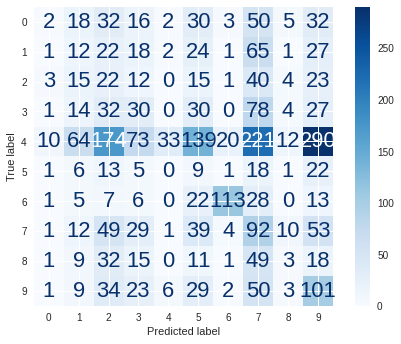

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(split0['y_test'], predicted_mnb_eda
                                        , cmap=plt.cm.Blues)
#plt.figure(figsize=(10, 10))
plt.show()

### 2.Support Vector Machine

In [ ]:
from sklearn import svm

clf_svm_eda = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clf_svm_eda.fit(df_X_train_tfidf, split0['y_train'])

SVC(gamma='auto', kernel='linear')

Took 34 min.

In [65]:
import sklearn.metrics as metrics

In [66]:
predicted_svm_eda = clf_svm_eda.predict(X_test_tfidf)
print(metrics.classification_report(split0['y_test'], predicted_svm_eda) )

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


              precision    recall  f1-score   support

           0       0.10      0.14      0.12       190
           1       0.09      0.14      0.11       173
           2       0.06      0.13      0.09       135
           3       0.13      0.17      0.14       216
           4       0.61      0.30      0.40      1036
           5       0.04      0.07      0.05        76
           6       0.41      0.49      0.44       195
           7       0.11      0.12      0.11       290
           8       0.06      0.06      0.06       139
           9       0.15      0.16      0.15       258

    accuracy                           0.22      2708
   macro avg       0.18      0.18      0.17      2708
weighted avg       0.32      0.22      0.25      2708



In [67]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(split0['y_test'], predicted_svm_eda)

0.17805714255016472